In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Define Pareto Plotting Functions

In [59]:
def generate_pareto_chart_simple(
        df, pareto='pareto', count='frequency', style_name='seaborn-v0_8',
        x_label_rotation=0, dpi=175):
    """
    Generates a pareto chart from an input dataframe with 2 columns:
    1) pareto column for defects to plot
    2) count of each pareto/defect
    Parameters:
        pareto: default 'pareto'.  This is the pareto/defect column
        described above (1).
        count: default 'frequency'. This is the number of defects for
        each pareto described above (2)
        style_name: default 'seaborn-v0_8'.  Matplotlib style to be
        used for the plot.
        x_label_rotation: default 0.  Degrees to rotate x-labels.
        dpi: default 175.  Resolution of the plot.
    """

    summary_df = df.groupby([pareto]).agg({count:'sum'}).reset_index()
    summary_df = summary_df.sort_values(by=count, ascending=False)

    pareto_line = []
    for r, defect in enumerate(summary_df[pareto].unique()):
        ratio = 100*float(summary_df.iloc[0:r][count].sum())/float(summary_df[count].sum())
        pareto_line.append([r-1, ratio])
    pareto_line.append([r, 100*float(summary_df.iloc[0:r+1][count].sum())/float(summary_df[count].sum())])
    pareto_line = np.array(pareto_line)


    try:
        plt.style.use(style_name)
    except:
        plt.style.use('default')
    fig, axes_left = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
    axes_right = axes_left.twinx()
    sns.barplot(data=summary_df, x=pareto, y=count, ax=axes_left)
    axes_left.tick_params(axis='x', rotation=x_label_rotation)
    axes_left.set_ylabel(count)
    axes_right.plot(
        pareto_line[1:,0], pareto_line[1:,1], ls='-', marker='.', color='k'
    )
    axes_right.set_yticks(np.arange(0, 101, 10))
    axes_right.set_ylabel('Cumulative %')
    plt.grid(False)
    return fig

In [83]:
def generate_pareto_chart_detailed(
        df, pareto='pareto', subpareto='subpareto', count='frequency',
        style_name='seaborn-v0_8', x_label_rotation=0, dpi=175):

    """
    Generates a pareto chart from an input dataframe with 3 columns:
    1) pareto column for defects to plot
    2) subpareto or detailed defect.  This will be ploted as a distinct
    color in each bar.
    3) count of each pareto/defect subdivided by subpareto.
    Parameters:
        pareto: default 'pareto'.  This is the pareto/defect column
        described above (1).
        subpareto: default 'subpareto'.  This is the subpareto column
        described above (2).
        count: default 'frequency'. This is the number of defects for
        each pareto described above (3)
        style_name: default 'seaborn-v0_8'.  Matplotlib style to be
        used for the plot.
        x_label_rotation: default 0.  Degrees to rotate x-labels.
        dpi: default 175.  Resolution of the plot.
    """

    summary_df = df.groupby([pareto]).agg({count:'sum'}).reset_index()
    summary_df = summary_df.sort_values(by=count, ascending=False)

    pareto_line = []
    for r, defect in enumerate(summary_df[pareto].unique()):
        ratio = 100*float(summary_df.iloc[0:r][count].sum())/float(summary_df[count].sum())
        pareto_line.append([r-1, ratio])
    pareto_line.append([r, 100*float(summary_df.iloc[0:r+1][count].sum())/float(summary_df[count].sum())])
    pareto_line = np.array(pareto_line)


    defects = summary_df[pareto].unique()
    subdefects = df[subpareto].unique()

    num_colors = len(subdefects)
    if num_colors <= 10:
        cmap = plt.get_cmap('tab10')
    else:
        cmap = plt.get_cmap('tab20')
    sampled_colors = cmap(np.arange(0, num_colors))
    color_dict = {}
    for i, row in enumerate(sampled_colors):
        color_dict.update({subdefects[i]:row})

    try:
        plt.style.use(style_name)
    except:
        plt.style.use('default')

    width = 0.6
    bottom = np.zeros(len(defects))
    fig, axes_left = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
    axes_right = axes_left.twinx()
    for defect in defects:
        for subdefect in subdefects:
            subdf = df[(df[pareto] == defect) & (df[subpareto] == subdefect)]
            if subdf[count].shape == (0, ):
                continue
            freq = int(subdf[count].iloc[0])

            p = axes_left.bar(
                defect, freq, width, label=subdefect, bottom=bottom,
                color=color_dict[subdefect]
            )
            axes_left.bar_label(p, label_type='center')
            bottom += freq
        bottom = np.zeros(len(defects))


    handles, labels = axes_left.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    axes_left.legend(*zip(*unique), loc='center left', bbox_to_anchor=(1.09, 0.5))

    axes_left.tick_params(axis='x', rotation=x_label_rotation)
    axes_left.set_ylabel(count)

    axes_right.plot(pareto_line[1:,0], pareto_line[1:,1], ls='-', marker='.', color='k')
    axes_right.set_yticks(np.arange(0, 101, 10))
    axes_right.set_ylabel('Cumulative %')
    plt.grid(False)

    return fig

In [84]:
def generate_pareto_chart(
        df, pareto='pareto', subpareto='subpareto', count='frequency',
        style_name='seaborn-v0_8', x_label_rotation=0, dpi=175):

    """
    Wrapper function that calls either generate_pareto_chart_simple()
    or generate_pareto_chart_detailed() depending on the parameter
    subpareto.  If subpareto=None or subpareto=False, the wrapper will
    return the simplified plot.  If a string is provided, a detailed
    plot will be returned.

    Generates a pareto chart from an input dataframe with 3 columns:
    1) pareto column for defects to plot
    2) subpareto or detailed defect.  This will be ploted as a distinct
    color in each bar.
    3) count of each pareto/defect subdivided by subpareto.
    Parameters:
        pareto: default 'pareto'.  This is the pareto/defect column
        described above (1).
        subpareto: default 'subpareto'.  This is the subpareto column
        described above (2).
        count: default 'frequency'. This is the number of defects for
        each pareto described above (3)
        style_name: default 'seaborn-v0_8'.  Matplotlib style to be
        used for the plot.
        x_label_rotation: default 0.  Degrees to rotate x-labels.
        dpi: default 175.  Resolution of the plot.

    """


    if subpareto == False:
        fig = generate_pareto_chart_simple(
            df, pareto=pareto, count=count, style_name=style_name,
            x_label_rotation=x_label_rotation, dpi=dpi
        )
    elif subpareto == None:
        fig = generate_pareto_chart_simple(
            df, pareto=pareto, count=count, style_name=style_name,
            x_label_rotation=x_label_rotation, dpi=dpi
        )
    else:
        fig = generate_pareto_chart_detailed(
            df, pareto=pareto, subpareto=subpareto, count=count,
            style_name=style_name, x_label_rotation=x_label_rotation, dpi=dpi
        )
    return fig

# Generate Random Pareto DataFrame

In [55]:
max_freq = 45

df = pd.DataFrame([
    ['Pareto 1', 'Subpareto A', np.random.randint(1, max_freq)],
    ['Pareto 1', 'Subpareto B', np.random.randint(1, max_freq)],
    ['Pareto 1', 'Subpareto C', np.random.randint(1, max_freq)],
    ['Pareto 2', 'Subpareto A', np.random.randint(1, max_freq)],
    ['Pareto 2', 'Subpareto B', np.random.randint(1, max_freq)],
    ['Pareto 2', 'Subpareto C', np.random.randint(1, max_freq)],
    ['Pareto 3', 'Subpareto D', np.random.randint(1, max_freq)],
    ['Pareto 3', 'Subpareto E', np.random.randint(1, max_freq)],
    ['Pareto 3', 'Subpareto F', np.random.randint(1, max_freq)],
    ['Pareto 4', 'Subpareto D', np.random.randint(1, max_freq)],
    ['Pareto 4', 'Subpareto E', np.random.randint(1, max_freq)],
    ['Pareto 4', 'Subpareto F', np.random.randint(1, max_freq)],
    ['Pareto 5', 'Subpareto A', np.random.randint(1, max_freq)],
    ['Pareto 5', 'Subpareto B', np.random.randint(1, max_freq)],
    ['Pareto 5', 'Subpareto C', np.random.randint(1, max_freq)],
], columns=['Defect', 'Code', 'Count'])
display(df.head())

,Defect,Code,Count
0,Pareto 1,Subpareto A,12
1,Pareto 1,Subpareto B,18
2,Pareto 1,Subpareto C,15
3,Pareto 2,Subpareto A,39
4,Pareto 2,Subpareto B,2


# Plots

In [56]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


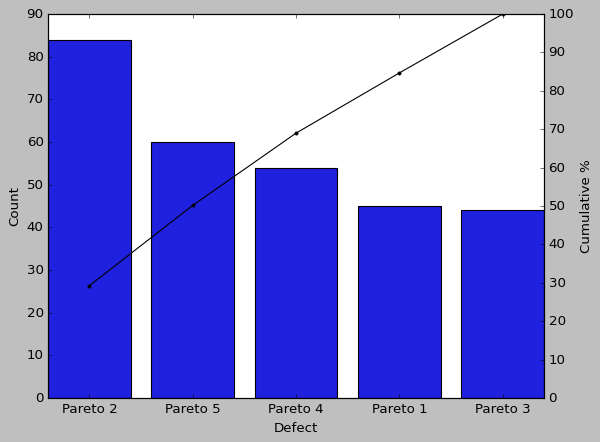

In [76]:
fig_simple = generate_pareto_chart(
    df, pareto='Defect', subpareto=False, count='Count',
    style_name='classic', x_label_rotation=0, dpi=75
)

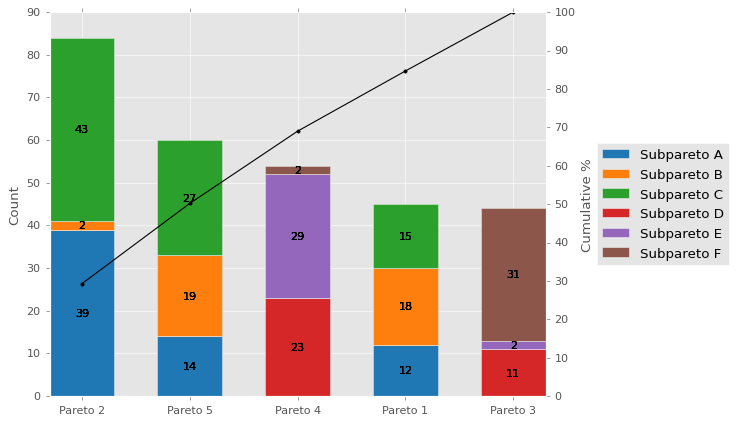

In [87]:
fig_detailed = generate_pareto_chart(
    df, pareto='Defect', subpareto='Code', count='Count',
    style_name='ggplot', x_label_rotation=0, dpi=100
)